In [1]:
#!/usr/bin/python3
# coding: utf-8
# Hokkaido

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
from jma_csvdl import save_jma_data, parse_jma_csv
import json
import matplotlib
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as offline
from plotly.subplots import make_subplots
import sys
if "ipy" in sys.argv[0]:
    offline.init_notebook_mode()
from PIL import Image
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int, \
    get_populations, get_os_idx_of_arr, dump_val_in_arr, \
    calc_last1w2w_dif, create_basic_scatter_figure, \
    show_and_save_plotly
from hokkaidomap import sub_prefs, get_sub_code, get_hokkaido

In [3]:
# 北海道 OpenData を参照する
# https://www.harp.lg.jp/opendata/dataset/1369.html
# 北海道は面積が広いため、振興局別に集計を行う
base_uri = "https://www.harp.lg.jp/opendata/dataset/1369/resource/3132/"
patients_file = "010006_hokkaido_covid19_patients.csv"
download_if_needed(base_uri, patients_file)
base_uri = "https://www.harp.lg.jp/opendata/dataset/1369/resource/2853/"
data_file = "covid19_data.csv"
download_if_needed(base_uri, data_file)

In [4]:
patients = []
# CSVデータを整形する
with codecs.open(patients_file, encoding="shift-jis") as f:
    l = f.readline() # 先頭行をスキップ
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 16:
            patients.append(
                [
                    code2int(arr[0]), # No
                    get_sub_code(arr[6]), # sub-pref code
                    arr[6], # sub-pref
                    dt.strptime(arr[4], "%Y-%m-%d"), # press date
                    arr[5], # infected 
                    arr[7], # Age
                    arr[8], # Sex
                ]
            )

print("Total: {}".format(len(patients)))

Total: 2763


In [5]:
# Pandas DataFrame を作成する
df = pd.DataFrame(patients, columns=['No', 'Code', 'State', 'Date', 'DoW', 'Age', 'Sex'])

In [6]:
# Daily の新規感染者を集計する
daily_new = df.groupby('Date').size()
print("Daily New: {}".format(daily_new[-1]))
# duration
frm_date = daily_new.index[0]
end_date = daily_new.index[-1]
print("From: {} To: {}".format(frm_date, end_date))
# moving average by week
ave_mov_days = 7
# 移動平均を算出する
mov_mean = daily_new.rolling(ave_mov_days).mean()

Daily New: 60
From: 2020-01-28 00:00:00 To: 2020-10-24 00:00:00


In [7]:
# 4 weeks later
xbins = daily_new.index.tolist()
days2pred = 2 * ave_mov_days # 2 weeks
# 2週間先の日付列を取得する
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.copy()
xbins_pred.extend(two_weeks_later)

X = np.arange(0, len(daily_new.index.values))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]
y_gpr = get_gpr_predict(X, daily_new.values, X_pred, 80, 10, 200)

y 0 val = 60.


In [8]:
if False:
    fig, ax = create_basic_plot_figure()
    ymax = max(daily_new)
    plt.title('北海道 新型コロナ予測 新規感染者数', fontname=FONT_NAME)
    plt.xlim(xbins_pred[ave_mov_days], xbins_pred[-1])
    plt.ylim(0, ymax)
    plt.plot(xbins, daily_new,  '.', linewidth=1, color='#c0ffc0')
    plt.bar(xbins, mov_mean, color='#008080', edgecolor='#008080', alpha=1)
    plt.legend(labels=["新規", "７日移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
    ax2 = ax.twinx()
    plt.plot(xbins_pred, y_gpr, '-', linewidth=1.5, color='#ff8080')
    plt.ylim(0, ymax)
    plt.legend(labels=["ガウス過程回帰"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
    show_and_clear(fig, "docs/images/hokkaido.jpg")

In [9]:
save_jma_data("sapporo-jma.csv", city_code="s47412")
weather_sapporo = parse_jma_csv("sapporo-jma.csv")
print("Loaded {} data.".format(len(weather_sapporo)))
df_weather = pd.DataFrame(weather_sapporo, columns=['Date', 'Temp', 'Humi'])
fig = px.scatter(df_weather, x='Date', y=['Temp', 'Humi'])
fig.update_layout(template='plotly_dark')
if "ipy" in sys.argv[0]:
    fig.show()

2020 10 24
PHP Session ID: 1g0lp3our0ndkdrc32ilr57vp7
200
Wrote 8141 bytes into sapporo-jma.csv
Loaded 298 data.


In [10]:
np_weather = np.array(weather_sapporo)

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(
    x=xbins, y=daily_new, mode='markers', name='新規',
    marker=dict(size=4)), secondary_y=False)
fig.add_trace(go.Bar(
    x=xbins, y=mov_mean, name='7日移動平均', opacity=0.6),
    secondary_y=False)
fig.add_trace(go.Scatter(
    x=xbins_pred, y=y_gpr, mode='lines', name='予測',
    line=dict(width=1)), secondary_y=False)
fig.add_trace(go.Scatter(
    x=np_weather[:, 0], # 日付
    y=np_weather[:, 1], # 気温
    name="日別平均気温",
    line=dict(width=1)), secondary_y=True)
fig.update_layout(
    xaxis=dict(title='日付', type='date',
               dtick=604800000.0, tickformat="%_m/%-d",
               range=(xbins[4], xbins_pred[-1])),
    yaxis=dict(title='人数'),
    yaxis2=dict(title='日別平均気温[℃]'),
    title='北海道 新型コロナ予測 新規感染者数/日別平均気温',
)
show_and_save_plotly(fig, "hokkaido.jpg", js=False)

wrote to docs/images/hokkaido.jpg
wrote to docs/_includes/hokkaido.html


In [12]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "北海道 新型コロナ予測 新規感染者数(北海道 " + today_str + " 時点)"
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tw_body += "(気象業務法第13～24条に接触するため、予報を含まない前日までの気温を表示) "
tw = get_twitter()
tweet_with_image(tw, "docs/images/hokkaido.jpg", tw_body)

In [13]:
cov19data = []
# CSVデータを整形する
with codecs.open(data_file, encoding="shift-jis") as f:
    l = f.readline() # 先頭行をスキップ
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 23:
            tracked = blank2zero(arr[20])
            untracked = blank2zero(arr[21])
            unknown_rate = (untracked / max(1.0, (tracked + untracked))) * 100.0
            #print(tracked, untracked, unknown_rate)
            cov19data.append(
                [
                    dt(int(arr[1]), int(arr[2]), int(arr[3])), # date
                    blank2zero(arr[4]),  # tests
                    blank2zero(arr[6]),  # positive
                    blank2zero(arr[19]), # postive rate [%]
                    tracked, # tracked 濃厚接触
                    untracked,  # untracked 濃厚接触以外
                    unknown_rate # 経路不明率
                ]
            )

print("Total: {}".format(len(cov19data)))

Total: 271


In [14]:
pos_rate_np = np.array(cov19data)
#print("{}".format(pos_rate_np))

In [15]:
xbins = pos_rate_np[:, 0]
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.tolist()
xbins_pred.extend(two_weeks_later)
X = np.arange(0, len(pos_rate_np[:, 0]))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]

y_test = get_gpr_predict(X, pos_rate_np[:, 1], X_pred)
y_rate = get_gpr_predict(X, pos_rate_np[:, 3], X_pred)
y_unkn = get_gpr_predict(X, pos_rate_np[:, 6], X_pred)

y 0 val = 1052.
y 0 val = 5.7.
y 0 val = 40.0.


In [16]:
if False:
    fig, ax = create_basic_plot_figure()
    plt.title('北海道 新型コロナ予測 検査人数/陽性率', fontname=FONT_NAME)
    plt.ylabel('人数', fontname=FONT_NAME)
    plt.ylim(0, max(pos_rate_np[:, 1])+100)
    plt.plot(xbins, pos_rate_np[:, 1], '.', linewidth=1.5, color='#00ff00')
    plt.plot(xbins_pred, y_test, '-', color='#00ff00', linewidth=1)
    plt.bar(xbins, moving_average(pos_rate_np[:, 1]), color='#008000', edgecolor='#008000', alpha=.75)
    plt.legend(labels=["検査人数", "予測値", "移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
    ax2 = ax.twinx()
    plt.ylim(0, 50)
    ax2.plot(xbins_pred, y_rate, '-', color='pink', linewidth=1)
    ax2.bar(xbins, pos_rate_np[:, 3], color='pink', edgecolor='pink', alpha=.5)
    plt.legend(labels=["予測値", "陽性率[%]"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
    show_and_clear(fig, "docs/images/hokkaido-rate.jpg")

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xbins, y=pos_rate_np[:, 1], mode='markers', name='検査人数',
                                       marker=dict(size=4)), secondary_y=False)
fig.add_trace(go.Bar(x=xbins, y=moving_average(pos_rate_np[:, 1]), name='移動平均', opacity=0.5), 
                    secondary_y=False)
fig.add_trace(go.Scatter(x=xbins_pred, y=y_test, mode='lines', name='予測値',
                         line=dict(width=1)), secondary_y=False)
fig.add_trace(go.Bar(x=xbins, y=pos_rate_np[:, 3], name="陽性率[%]", opacity=0.5),
                         secondary_y=True)
fig.add_trace(go.Scatter(x=xbins_pred, y=y_rate, name="予測値",
                         line=dict(width=1)), secondary_y=True)
fig.update_layout(
    xaxis=dict(title='日付', type='date',
               dtick=604800000.0, tickformat="%_m/%-d",
               range=[xbins_pred[30], xbins_pred[-1]]),
    yaxis=dict(title='人数', range=[0, np.max(pos_rate_np[:, 1])]),
    yaxis2=dict(title='陽性率[%]', range=[0, np.max(pos_rate_np[:, 3])]),
    title='北海道 新型コロナ予測 検査人数/陽性率',
)
show_and_save_plotly(fig, "hokkaido-rate.jpg", js=False)

wrote to docs/images/hokkaido-rate.jpg
wrote to docs/_includes/hokkaido-rate.html


In [18]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "北海道 新型コロナ予測 検査人数/陽性率(北海道 " + today_str + " 時点)"
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tweet_with_image(tw, "docs/images/hokkaido-rate.jpg", tw_body)

In [19]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xbins, y=pos_rate_np[:, 1], mode='markers', name='検査人数',
                                       marker=dict(size=4)), secondary_y=False)
fig.add_trace(go.Bar(x=xbins, y=moving_average(pos_rate_np[:, 1]), name='移動平均', opacity=0.5), 
                    secondary_y=False)
fig.add_trace(go.Scatter(x=xbins_pred, y=y_test, mode='lines', name='予測値',
                         line=dict(width=1)), secondary_y=False)
fig.add_trace(go.Bar(x=xbins, y=pos_rate_np[:, 6], name="経路不明率[%]", opacity=0.5),
                         secondary_y=True)
fig.add_trace(go.Scatter(x=xbins_pred, y=y_unkn, name="予測値",
                         line=dict(width=1)), secondary_y=True)
fig.update_layout(
    xaxis=dict(title='日付', type='date',
               dtick=604800000.0, tickformat="%_m/%-d",
               range=[xbins_pred[30], xbins_pred[-1]]),
    yaxis=dict(title='人数', range=[0, np.max(pos_rate_np[:, 1])]),
    yaxis2=dict(title='経路不明率[%]', range=[0, np.max(pos_rate_np[:, 6])]),
    title='北海道 新型コロナ予測 検査人数/経路不明率',
)
show_and_save_plotly(fig, "hokkaido-unknown.jpg", js=False)

wrote to docs/images/hokkaido-unknown.jpg
wrote to docs/_includes/hokkaido-unknown.html


In [20]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "北海道 新型コロナ予測 検査人数/経路不明率(北海道 " + today_str + " 時点)"
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tweet_with_image(tw, "docs/images/hokkaido-unknown.jpg", tw_body)

In [21]:
def make_hokkaido_plotly(filename, title, npa1d):
    """ 北海道のヒートマップを作成する """
    fig = go.Figure()
    w=600
    h=528
    cmap = plt.get_cmap("rainbow")
    norm = plt.Normalize(vmin=np.min(npa1d), vmax=np.max(npa1d))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    map_cols = {}
    for k, v in sub_prefs.items():
        map_cols[k] = fcol(npa1d[k])
    pict = get_hokkaido(map_cols)
    fig.add_trace(go.Scatter(x=[0, w], y=[0, h], mode='markers', marker_opacity=0))
    fig.add_trace(go.Heatmap(x=[0, 0], y=[0, 0], opacity=0,
        z=[np.min(npa1d[1:]), np.max(npa1d[1:])],
        zmin=np.min(npa1d[1:]), zmax=np.max(npa1d[1:]),
        type='heatmap', colorscale='Rainbow', showscale=True))
    map_cols = {}
    axis_template = lambda x: dict(
        range=[0, x], autorange=False, showgrid=False, zeroline=False,
        linecolor='black', showticklabels=False, ticks='')
    fig.update_layout(title=title, xaxis=axis_template(w), yaxis=axis_template(h),
                     showlegend=False, width=w, height=h, autosize=False,
                      margin={"l": 0, "r": 0, "t":40, "b": 0}
                     )
    fig.add_layout_image(dict(
            x=0, sizex=w, y=h, sizey=h, xref="x", yref="y", opacity=1,
            layer="below", sizing="stretch", source=Image.fromarray(pict)))
    show_and_save_plotly(fig, filename, js=False, show=True, image=True, html=False)

In [22]:
def make_hokkaido_choropleth(filename, title, npa1d):
    """ 北海道の choropleth を作成する """
    f = codecs.open("hokkaido-min.geojson", "r", encoding='utf-8')
    geojson = json.load(f)
    f.close()
    df = pd.read_csv('hokkaido.txt', header=0, index_col=0,
                 dtype={'code':str, 'total':int, 'subcode':str, 'color':float})
    i = 0
    for c in npa1d:
        df.loc[i, 'color'] = c
        i += 1
    
    fig = px.choropleth(df, geojson=geojson, color="color", hover_name='name',
                    locations="subcode", featureidkey="properties.code",
                    labels={'color':'値', 'subcode':'自治体コード'},
                    projection="mercator", title=title)
    fig.update_geos(visible=False,
                    lonaxis=dict(range=[139.772386, 145.792893]),
                    lataxis=dict(range=[41.383390, 45.531737]))
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    show_and_save_plotly(fig, filename, js=False, show=False, image=False, html=True)

wrote to docs/_includes/hokkaido-all.html



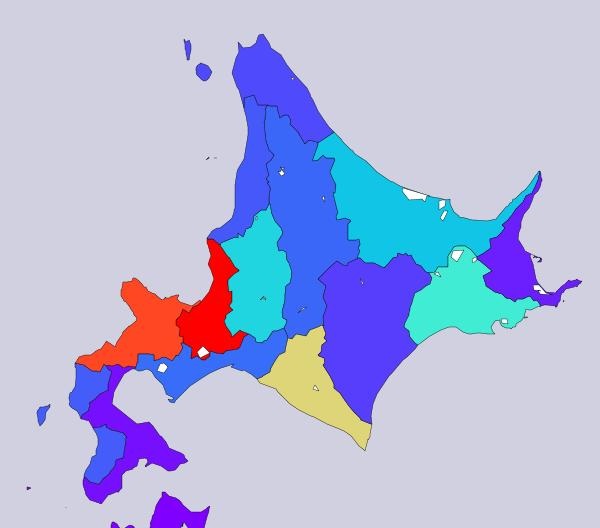

wrote to docs/images/hokkaido-all.jpg


In [23]:
tw_body = "北海道 新型コロナ情報 振興局別 罹患率[全期間] (北海道 " + today_str + " 時点)"
imgname = "hokkaido-all.jpg"
# 振興局別感染者数
sub_poss = df.groupby('Code').size()
#print("Sub-pref Pos: {}".format(sub_poss))
vals = np.zeros(len(sub_prefs.keys()), dtype=float)
for i in range(len(vals)):
    if i not in sub_poss.index:
        sub_poss.loc[i] = 0
#print(sub_poss)
for i in sub_poss.index:
    #print(i, sub_prefs[i]['code'])
    vals[i] = (sub_poss[i] / sub_prefs[i]['total']) * 100.0
#print(vals)
make_hokkaido_choropleth(imgname, tw_body, vals)
make_hokkaido_plotly(imgname, tw_body, vals)

In [24]:
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tweet_with_image(tw, "docs/images/{}".format(imgname), tw_body)

wrote to docs/_includes/hokkaido-all-n.html



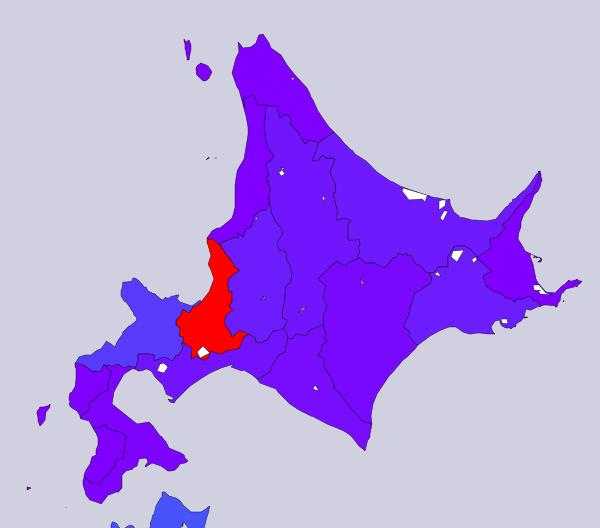

wrote to docs/images/hokkaido-all-n.jpg


In [25]:
tw_body = "北海道 新型コロナ情報 振興局別 陽性者数[全期間] (北海道 " + today_str + " 時点)"
imgname = "hokkaido-all-n.jpg"
vals = np.zeros(len(sub_prefs.keys()), dtype=float)
for i in range(len(vals)):
    if i not in sub_poss.index:
        sub_poss.loc[i] = 0
for i in sub_poss.index:
    vals[i] = sub_poss[i]
make_hokkaido_choropleth(imgname, tw_body, vals)
make_hokkaido_plotly(imgname, tw_body, vals)

In [26]:
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tweet_with_image(tw, "docs/images/{}".format(imgname), tw_body)

In [27]:
dt_last1w = end_date - td(7)
dt_last2w = end_date - td(14)
print(end_date, dt_last1w, dt_last2w)
# 直近1週間
df_last1w = df[df['Date'] > dt_last1w]
sub_last1w = df_last1w.groupby('Code').size()
# 直近2週間
df_last2w = df[df['Date'] > dt_last2w]
sub_last2w = df_last2w.groupby('Code').size()
# 直近1週間陽性者数
sub_pos_last1w = np.zeros(len(sub_prefs))
cnt = 0
for i in sub_last1w.index.to_list():
    sub_pos_last1w[i] = sub_last1w.values[cnt]
    cnt +=1
print(sub_pos_last1w.astype(int))
# 直近2週間陽性者数
sub_pos_last2w = np.zeros(len(sub_prefs))
cnt = 0
for i in sub_last2w.index.to_list():
    sub_pos_last2w[i] = sub_last2w.values[cnt]
    cnt += 1
print(sub_pos_last2w.astype(int))

2020-10-24 00:00:00 2020-10-17 00:00:00 2020-10-10 00:00:00
[ 34 154   1   0  11   2   1   0   1   0   1   4   2  33   1]
[ 48 241   2   0  24  16   5   0   1   0  10  27   2  39   1]


In [28]:
# 計算式は「（直近7日間の新規陽性者数／その前7日間の新規陽性者数）^（平均世代時間／報告間隔）」
agt = 5 # 平均世代時間
ri = 7 #報告間隔
min_smpl = 5 # 最低サンプリング数
Rt = []
for i in np.arange(len(sub_pos_last1w)):
    div = (sub_pos_last2w[i] - sub_pos_last1w[i])
    if div == 0 and sub_pos_last1w[i] > 0:
        Rt.append(1.0) # 0から増加した場合は他地域からの流入
    elif div == 0:
        Rt.append(0.0) # 0を維持
    elif sub_pos_last2w[i] < min_smpl and sub_pos_last1w[i] < min_smpl:
        Rt.append(1) # サンプリングが少ない場合、1 と仮定
    else:
        r = (sub_pos_last1w[i] / div) ** (agt / ri)
        Rt.append(r)
print(Rt)

[1.8847364492984695, 1.5036401229929615, 1, 0.0, 0.8875198903799592, 0.2490912906099462, 0.3714985722842371, 0.0, 1.0, 0.0, 0.20816044495271988, 0.2866685904019024, 1.0, 3.379329134040103, 1.0]


wrote to docs/_includes/hokkaido-Rt.html



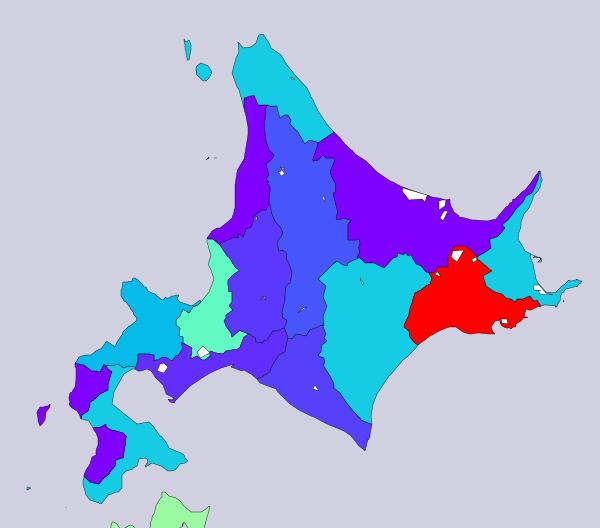

wrote to docs/images/hokkaido-Rt.jpg


In [29]:
tw_body = "北海道 新型コロナ情報 振興局別 実効再生産数[簡易計算] (北海道 " + today_str + " 時点)"
imgname = "hokkaido-Rt.jpg"
make_hokkaido_choropleth(imgname, tw_body, Rt)
make_hokkaido_plotly(imgname, tw_body, Rt)
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tweet_with_image(tw, "docs/images/{}".format(imgname), tw_body)

[0.0004800000480000048, 0.010103525501549906, 0.0005181964690092602, 0.0, 0.01185776609568229, 0.005621668722089293, 0.0010278971280554242, 0.0, 0.0016129032258064516, 0.0, 0.0026011320126519064, 0.04171494785631518, 0.0005962460349638675, 0.017321170022828417, 0.0013679516292303905]
wrote to docs/_includes/hokkaido-2w.html



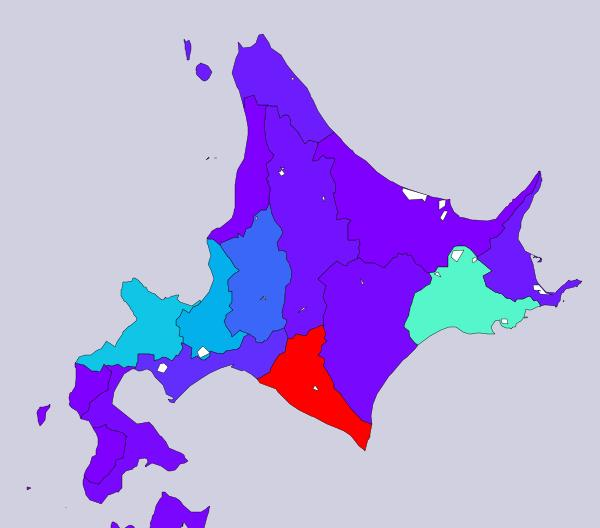

wrote to docs/images/hokkaido-2w.jpg


In [30]:
tw_body = "北海道 新型コロナ情報 振興局別 直近2週間罹患率 (北海道 " + today_str + " 時点)"
imgname = "hokkaido-2w.jpg"
vals = []
for k, v in sub_prefs.items():
    vals.append((sub_pos_last2w[k] / v['total']) * 100.0)
print(vals)
make_hokkaido_choropleth(imgname, tw_body, vals)
make_hokkaido_plotly(imgname, tw_body, vals)
tw_body += " https://geneasyura.github.io/cov19-hm/hokkaido.html "
tweet_with_image(tw, "docs/images/{}".format(imgname), tw_body)